# Notebook to show results

Import libraries needed

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

In [2]:
from modules.config import (RESULTS_DIR,
                            RESULTS_FILE, 
                            GRAPH_DIR,
                            )

SPACE = ' '

## define standard function modules

In [3]:
def read_data():
    """read data from csv file into pandas dataframe"""
    results_path = Path(RESULTS_DIR).joinpath(RESULTS_FILE)
    df = pd.read_csv(results_path)
    return df

In [4]:
def filter_results_general(df):
    """based on standard parameters"""    
    df = df[(df['formulation'] == 'original')]
    df = df[(df['hot_start'] == False)]
    df = df[(df['gray'] == False)]
    df = df[(df['iterations'] == 250)]
    return df

Filter out records for analysis

In [5]:
def filter_results_qml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == True)]
    df = filter_results_general(df)
    df = df[(df['gradient_type'] == 'SPSA')]
    df = df[(df['alpha'] == 0.602)]
    df = df[(df['big_a'] == 25)]
    df = df[(df['c'] == 0.314)]
    df = df[(df['gamma'] == 0.101)]
    df = df[(df['eta'] == 0.1)]
    df = df[(df['s'] == 0.5)]
    df = df[(df['shots'] == 1024)]
    return df

In [6]:
def filter_results_ml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == False)]
    df = filter_results_general(df)
    df = df[(df['shots'] == 64)]
    df = df[(df['std_dev'] == 0.05)]
    df = df[(df['lr'] == 2e-5)]
    df = df[(df['weight_decay'] == 0.0006)]
    df = df[(df['momentum'] == 0.8)]
    return df

In [7]:
def find_quality(df):
    df['quality'] =  df['best_dist'] / df['best_dist_found'] 
    df['error'] = 1 - df['quality']
    return df

In [8]:
def select_key_fields_qml(df):
    df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]
    return df

In [9]:
def select_key_fields_ml(df):
    df = df[['locations', 'iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'layers', 'elapsed']]
    return df

## Analysis of slicing

In [10]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head(20)

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
169,10,1.0,2,290.2,290.2,1.000000,0.000000,2
179,10,1.0,73,290.2,290.2,1.000000,0.000000,2
192,10,1.0,116,290.2,290.2,1.000000,0.000000,2
204,10,1.0,12,290.3,290.2,0.999656,0.000344,2
671,9,1.0,181,286.7,286.7,1.000000,0.000000,2
672,10,1.0,84,290.2,290.2,1.000000,0.000000,2
678,9,0.9,5,286.7,286.7,1.000000,0.000000,2
679,10,0.9,17,290.2,290.2,1.000000,0.000000,2
685,9,0.8,53,286.7,286.7,1.000000,0.000000,2
686,10,0.8,50,290.2,290.2,1.000000,0.000000,2


In [11]:
#grouped_means = df.groupby(['locations', 'slice']).mean().reset_index()
#sliced_summary = df.groupby(['locations', 'slice']).mean().reset_index()
#standard_error= df.groupby(['locations', 'slice']).sem().reset_index()
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()

#grouped_means = df.groupby(['locations', 'slice']).count().reset_index()
#grouped_means.head()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head(100)


,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000418,0.000418
3,9,0.4,0.000418,0.000418
4,9,0.5,0.000000,0.000000
5,9,0.6,0.000000,0.000000
6,9,0.7,0.000000,0.000000
7,9,0.8,0.000418,0.000418
8,9,0.9,0.000000,0.000000
9,9,1.0,0.000000,0.000000


In [12]:
def plot_3d_graph_models(grouped_means, input):
    """plot a 3D bar graph of the given input data grouped by layers and locations"""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    layers = sorted(grouped_means['layers'].unique())
    locations = sorted(grouped_means['locations'].unique(), reverse=True)

    #errors = np.full(10, 0.1)

    layer_map = {sli: i for i, sli in enumerate(layers)}
    loc_map = {loc: i for i, loc in enumerate(locations)}
    
    # Assign colors for each location
    colors = plt.get_cmap('Set3', len(layers))  # or 'Set3', 'Paired', etc.
    layer_colors = {layer: colors(i) for i, layer in enumerate(layers)}

    # Bar sizes
    dx = 0.5
    dy = 0.15

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = loc_map[row['locations']] - dx/2    # Center the bar on the x-axis
        y = layer_map[row['layers']] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = layer_colors[row['layers']]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Locations')
    ax.set_ylabel('Layers')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(loc_map.values()))
    ax.set_xticklabels(list(loc_map.keys()))
    ax.set_yticks(list(layer_map.values()))
    ax.set_yticklabels(list(layer_map.keys()))

    legend_handles = [mpatches.Patch(color=layer_colors[layer], label=layer) for layer in layers]
    plt.legend(handles=legend_handles, title='Layers', loc='upper left', bbox_to_anchor=(1, 1))

    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

    formatted_input = input.replace('_', SPACE).title()
    title = f'3D Bar Graph of {formatted_input} by Layers and Locations'
    plt.title(title)
    filename = f'{input}_3d_bar_graph_models.png'
    filepath = Path(GRAPH_DIR).joinpath(filename)
    plt.savefig(filepath)
    plt.show()

In [13]:
def plot_3d_graph_slice(grouped_means, input, show_sem=False):
    """plot a 3D bar graph of the given input data grouped by locations and slice."""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    locations = grouped_means['locations'].unique()
    slices = sorted(grouped_means['slice'].unique())

    loc_map = {loc: i for i, loc in enumerate(locations)}
    slice_map = {sli: i for i, sli in enumerate(slices)}

    # Assign colors for each location
    colors = plt.get_cmap('Set3', len(locations))  # or 'Set3', 'Paired', etc.
    location_colors = {loc: colors(i) for i, loc in enumerate(locations)}

    # Bar and cap width sizes
    dx = 0.5
    dy = 0.25
    cap_width = 0.1

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = slice_map[row['slice']]   
        y = loc_map[row['locations']]
        x_bar = slice_map[row['slice']] - dx/2    # Center the bar on the x-axis
        y_bar = loc_map[row['locations']] - dy/2  # Center the bar on the y-axis
        z_bar = 0
        dz = row[input]
        if show_sem:
            error = row['sem']

        color = location_colors[row['locations']]
        ax.bar3d(x_bar , y_bar, z_bar, dx, dy, dz, color=color, shade=True)
        
        x_center = x + dx / 4
        y_center = y + dy / 4
        y_center = y

        if show_sem:
            if error > 0:
                ax.plot(
                    [x_center , x_center],
                    [y_center, y_center],
                    [0, dz + error],
                    color='black',
                    linewidth=2
                    )
                
                    # Horizontal cap at the top
            
                ax.plot(
                    [x_center - cap_width, x_center + cap_width],
                    [y_center, y_center],
                    [dz + error, dz + error],
                    color='black',
                    linewidth=2
                    )

    # Label axes
    ax.set_xlabel('Slice')
    ax.set_ylabel('Locations')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(slice_map.values()))
    ax.set_xticklabels(list(slice_map.keys()))
    ax.set_yticks(list(loc_map.values()))
    ax.set_yticklabels(list(loc_map.keys()))

    legend_handles = [mpatches.Patch(color=location_colors[loc], label=loc) for loc in locations]
    plt.legend(handles=legend_handles, title='Locations', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).title()
    title = f'3D Bar Graph of {formatted_input} by Location and Slice'
    plt.title(title)
    filename = f'{input}_3d_bar_graph_slices.png'
    filepath = Path(GRAPH_DIR).joinpath(filename)
    plt.savefig(filepath)
    plt.show()

In [14]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000418,0.000418
3,9,0.4,0.000418,0.000418
4,9,0.5,0.000000,0.000000


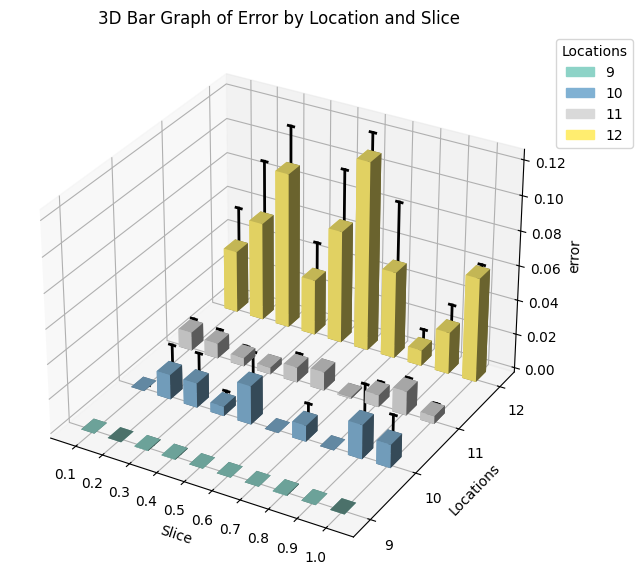

In [15]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

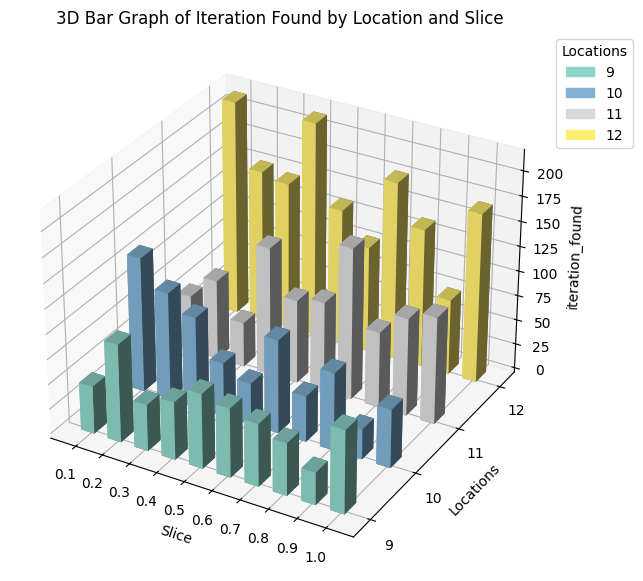

In [16]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()


input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of qml models

In [17]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 1.0)]

In [18]:
mode_summary = df.groupby(['mode', 'locations']).mean().reset_index()
mode_summary.head()

,mode,locations,slice,iteration_found,best_dist_found,best_dist,quality,error
0,1,4,1.0,0.0,21.0,21.0,1.0,0.0
1,1,5,1.0,0.0,19.0,19.0,1.0,0.0
2,1,6,1.0,5.0,241.0,241.0,1.0,0.0
3,1,7,1.0,0.0,276.2,276.2,1.0,0.0
4,1,8,1.0,2.5,277.2,277.2,1.0,0.0


## Analysis of ml models

In [19]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [20]:
df.head()

,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,layers,elapsed
573,10,6,447.100006,290.2,0.649072,0.350928,8,2,202.633927
591,10,9,328.700012,290.2,0.882872,0.117128,8,2,208.004263
610,10,26,356.700012,290.2,0.813569,0.186431,8,1,215.333851
611,10,4,424.500000,290.2,0.683628,0.316372,8,2,222.882087
612,10,5,422.700012,290.2,0.686539,0.313461,8,2,200.864060


In [21]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()
#grouped_means3 = df.groupby(['locations', 'layers']).count().reset_index()
layers_summary.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,elapsed
0,1,4,0.0,21.000000,21.0,1.000000,0.000000,8.0,36.065529
1,1,5,0.0,19.000000,19.0,1.000000,0.000000,8.0,51.213325
2,1,6,0.0,256.299988,241.0,0.940304,0.059696,8.0,77.375575
3,1,7,2.0,308.000000,276.2,0.896753,0.103247,8.0,118.169566
4,1,8,51.0,277.700012,277.2,0.998199,0.001801,8.0,146.837071


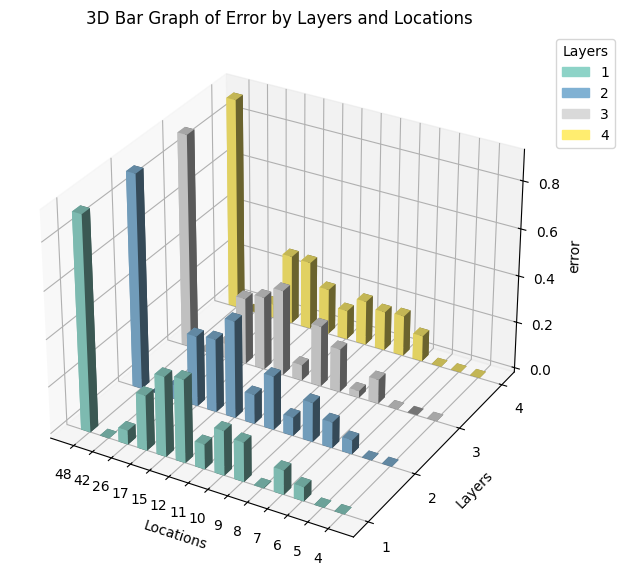

In [22]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [23]:
layers_means = df.groupby(['locations', 'layers',]).mean().reset_index()
#grouped_means4.head(100)

In [24]:
#grouped_means4 = grouped_means4[(grouped_means4['locations'] < 45)]
ml_means = layers_means.groupby(['layers',]).mean().reset_index()
ml_means.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,elapsed
0,1,15.714286,28.202381,8708.421429,1185.821429,0.820098,0.179902,8.0,609.542481
1,2,15.714286,39.928571,8823.215476,1185.821429,0.802947,0.197053,8.0,589.913110
2,3,15.714286,30.000000,9039.450001,1185.821429,0.816347,0.183653,8.0,637.501351
3,4,15.714286,35.785714,8422.871427,1185.821429,0.820897,0.179103,8.0,661.197141


# Impact of hot start

In [25]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df['quality'] =  100 * df['best_dist'] / df['best_dist_found'] 
df['error'] = 100 - df['quality']


df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [26]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()
#grouped_means6 = df.groupby(['hot_start', 'locations', ]).count().reset_index()

#grouped_means6.head()

In [27]:
pivot = hot_qml_mean.pivot_table(index='locations', columns='hot_start', values='quality')
pivot = pivot.round(2)
print(pivot)

hot_start   False   True 
locations                
4          100.00  100.00
5          100.00  100.00
6          100.00  100.00
7          100.00  100.00
8          100.00  100.00
9           99.96  100.00
10         100.00   98.90
11          99.30  100.00
12          99.09   93.34


In [28]:
hot_summary = hot_qml_mean.groupby(['hot_start',]).mean().reset_index()
hot_summary.head(20)

,hot_start,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,8.0,0.8,39.348148,218.465185,217.944444,99.817077,0.182923,2.0
1,True,8.0,0.8,75.488889,220.664444,217.944444,99.137975,0.862025,2.0


In [29]:
### Classical ML
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

#df = find_quality(df)
df['quality'] =  100 * df['best_dist'] / df['best_dist_found'] 
df['error'] = 100 - df['quality']

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]



In [30]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()
#grouped_means8 = df.groupby(['hot_start', 'locations', ]).count().reset_index()

#grouped_means8.head()

In [31]:
pivot = hot_ml_mean.pivot_table(index='locations', columns='hot_start', values='quality')
pivot = pivot.round(2)
print(pivot)

hot_start   False   True 
locations                
4          100.00  100.00
5          100.00  100.00
6           97.02   88.65
7           89.34  100.00
8           90.72   94.59
9           85.05  100.00
10          80.51   91.73
11          89.46   93.02
12          66.90   78.75
15          68.72   70.37
17          72.24   70.67
26          94.08   77.95
42         100.00   77.69
48           9.24    9.36


In [32]:
hot_ml_summary = hot_ml_mean.groupby(['hot_start',]).mean().reset_index()
hot_ml_summary.head(20)

,hot_start,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,33.545918,8747.902551,1185.821429,81.661727,18.338273,8.015306
1,True,15.714286,1.0,44.311224,8664.162758,1185.821429,82.342026,17.657974,8.020408


## Impact of Gray encoding

###QML

In [33]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df['quality'] =  100 * df['best_dist'] / df['best_dist_found'] 
df['error'] = 100 - df['quality']


df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
#gray_mean_qml = df.groupby(['locations', 'gray', ]).count().reset_index()

gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', columns='gray', values='quality')
gray_qml_pivot = gray_qml_pivot.round(2)
print(gray_qml_pivot)


gray        False   True 
locations                
4          100.00  100.00
5          100.00  100.00
6          100.00  100.00
7          100.00  100.00
8          100.00  100.00
9           99.96   99.41
10         100.00   97.82
11          99.30   99.61
12          99.09   97.06


In [34]:
gray_summary_qml = gray_mean_qml.groupby(['gray',]).mean().reset_index()
gray_summary_qml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,8.0,0.8,39.348148,218.465185,217.944444,99.817077,0.182923,2.0
1,True,8.0,0.8,37.200000,220.002222,217.944444,99.321957,0.678043,2.0


qml

In [35]:
### Classical ML
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df['quality'] =  100 * df['best_dist'] / df['best_dist_found'] 
df['error'] = 100 - df['quality']

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()
#gray_mean_ml = df.groupby(['locations', 'gray', ]).count().reset_index()

gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(2)
print(gray_ml_pivot)

gray        False   True 
locations                
4          100.00  100.00
5          100.00  100.00
6           97.02  100.00
7           89.34  100.00
8           90.72   75.12
9           85.05   73.55
10          80.51   69.41
11          89.46   91.34
12          66.90   74.45
15          68.72   71.50
17          72.24   72.05
26          94.08   93.51
42         100.00  100.00
48           9.24    9.82


In [36]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,33.545918,8747.902551,1185.821429,81.661727,18.338273,8.015306
1,True,15.714286,1.0,35.142857,8260.092858,1185.821429,80.767402,19.232598,8.000000
